In [4]:
from google.colab import files

In [5]:
files.upload()


Saving kaggle (18).json to kaggle (18).json


{'kaggle (18).json': b'{"username":"sumitadangal","key":"5fe95e78187b742307f3a0a3aefc7e93"}'}

In [6]:
!mkdir ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/


In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d hijest/genre-classification-dataset-imdb

Dataset URL: https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb
License(s): other
 79% 33.0M/41.7M [00:00<00:00, 145MB/s] 
100% 41.7M/41.7M [00:00<00:00, 154MB/s]


In [10]:
!unzip genre-classification-dataset-imdb.zip -d train



Archive:  genre-classification-dataset-imdb.zip
  inflating: train/Genre Classification Dataset/description.txt  
  inflating: train/Genre Classification Dataset/test_data.txt  
  inflating: train/Genre Classification Dataset/test_data_solution.txt  
  inflating: train/Genre Classification Dataset/train_data.txt  


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [12]:
train_data = pd.read_csv("/content/train/Genre Classification Dataset/train_data.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
display(train_data.head())
print(train_data.shape)



<ipython-input-12-c5cd180aaf8c>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv("/content/train/Genre Classification Dataset/train_data.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])


,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


(54214, 4)


In [13]:
test_data = pd.read_csv("/content/train/Genre Classification Dataset/test_data.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
print(display(test_data.head()))
print(test_data.shape)

<ipython-input-13-25cb8d2a8447>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_data = pd.read_csv("/content/train/Genre Classification Dataset/test_data.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])


,ID,TITLE,GENRE,DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",NaN
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",NaN
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,NaN
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",NaN
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,NaN


None
(54200, 4)


In [14]:
test_solution_data = pd.read_csv("/content/train/Genre Classification Dataset/test_data_solution.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
print(display(test_solution_data.head()))
print(test_solution_data.shape)

<ipython-input-14-6d57f546945d>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_solution_data = pd.read_csv("/content/train/Genre Classification Dataset/test_data_solution.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])


,ID,TITLE,GENRE,DESCRIPTION
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


None
(54200, 4)


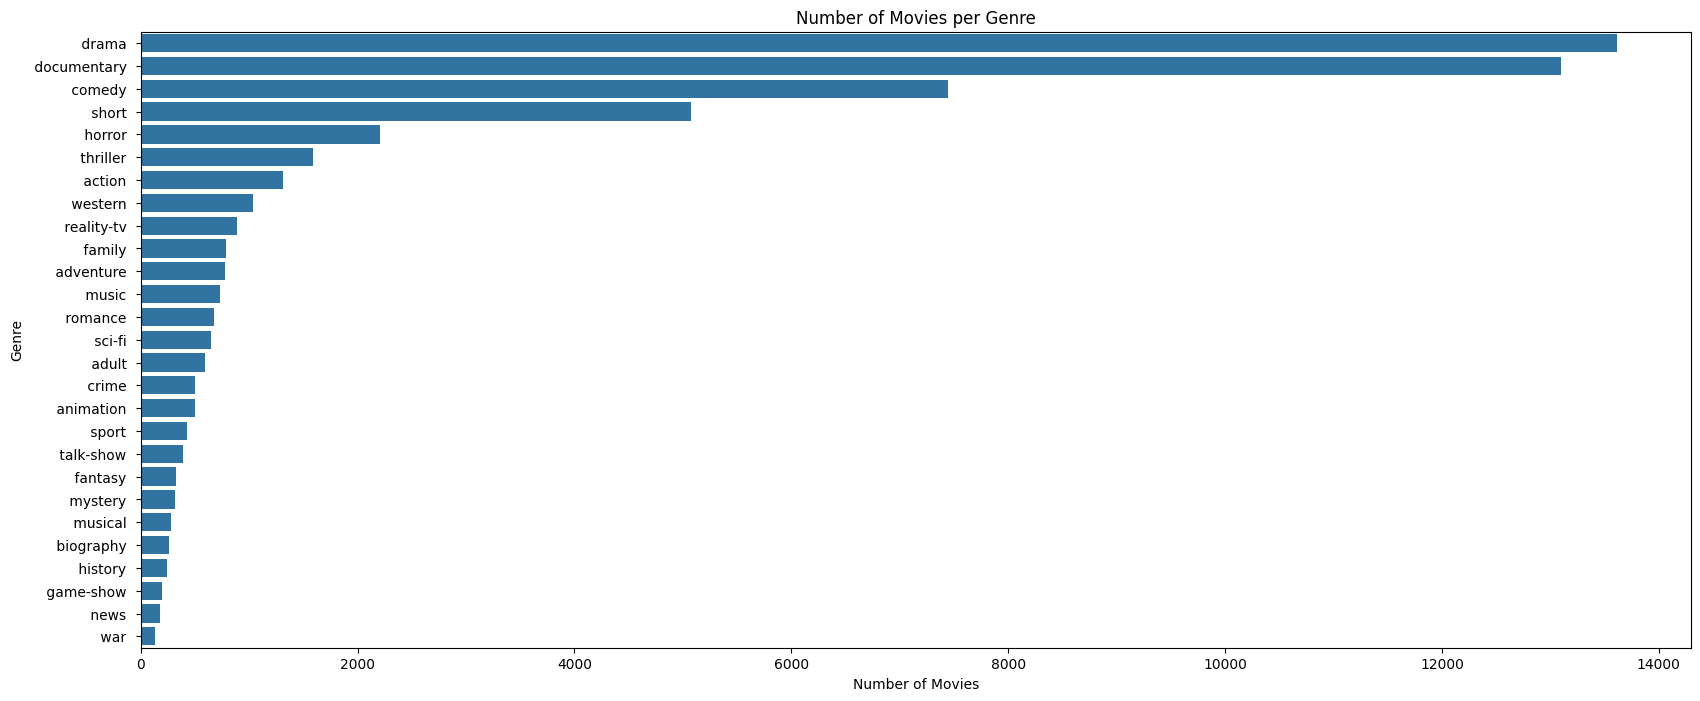

In [15]:
plt.figure(figsize=(20,8))
sns.countplot(y=train_data['GENRE'], order = train_data['GENRE'].value_counts().index)
plt.title('Number of Movies per Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

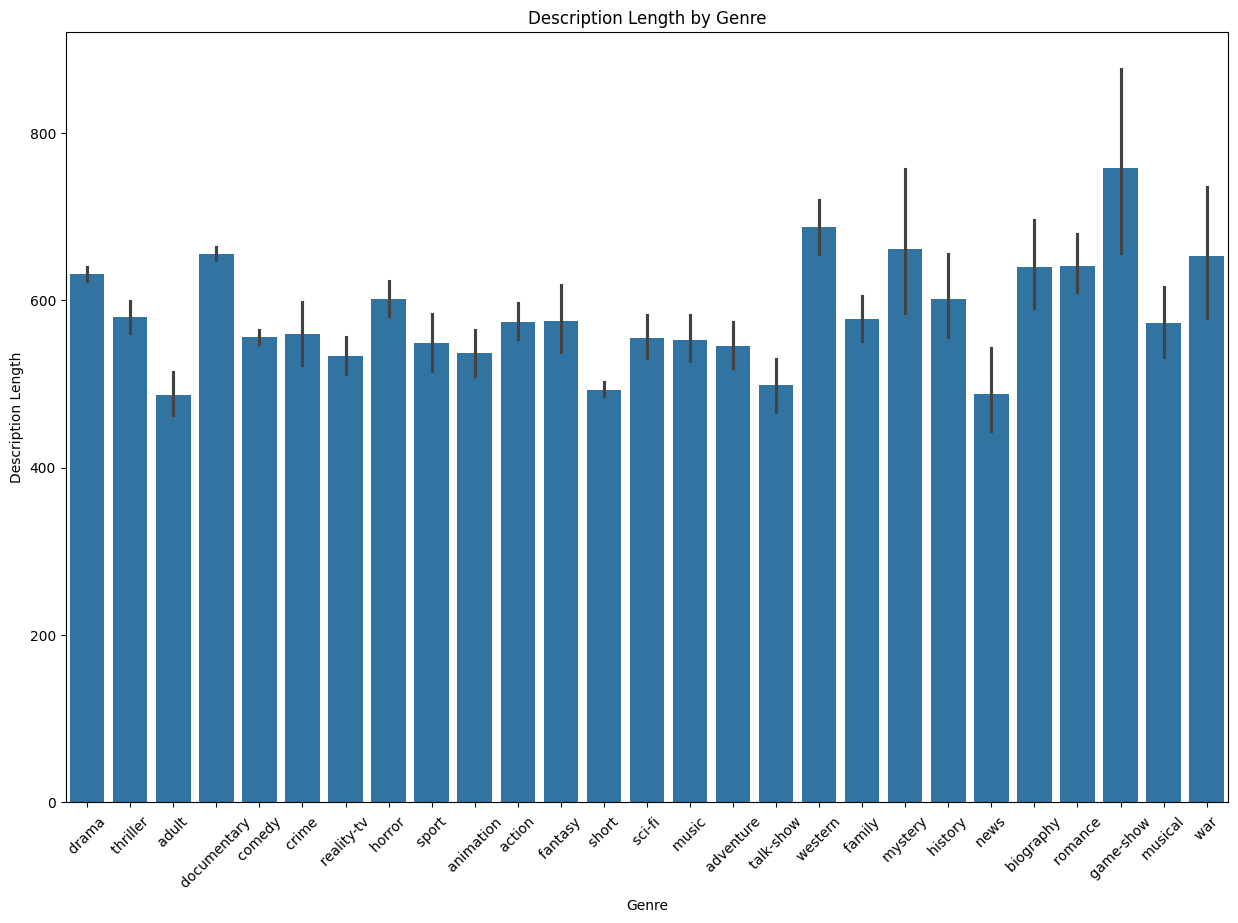

In [16]:
train_data['DESCRIPTION_length'] = train_data['DESCRIPTION'].apply(len)
plt.figure(figsize=(15, 10))
sns.barplot(x='GENRE', y='DESCRIPTION_length', data=train_data)
plt.title('Description Length by Genre')
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Description Length')
plt.show()

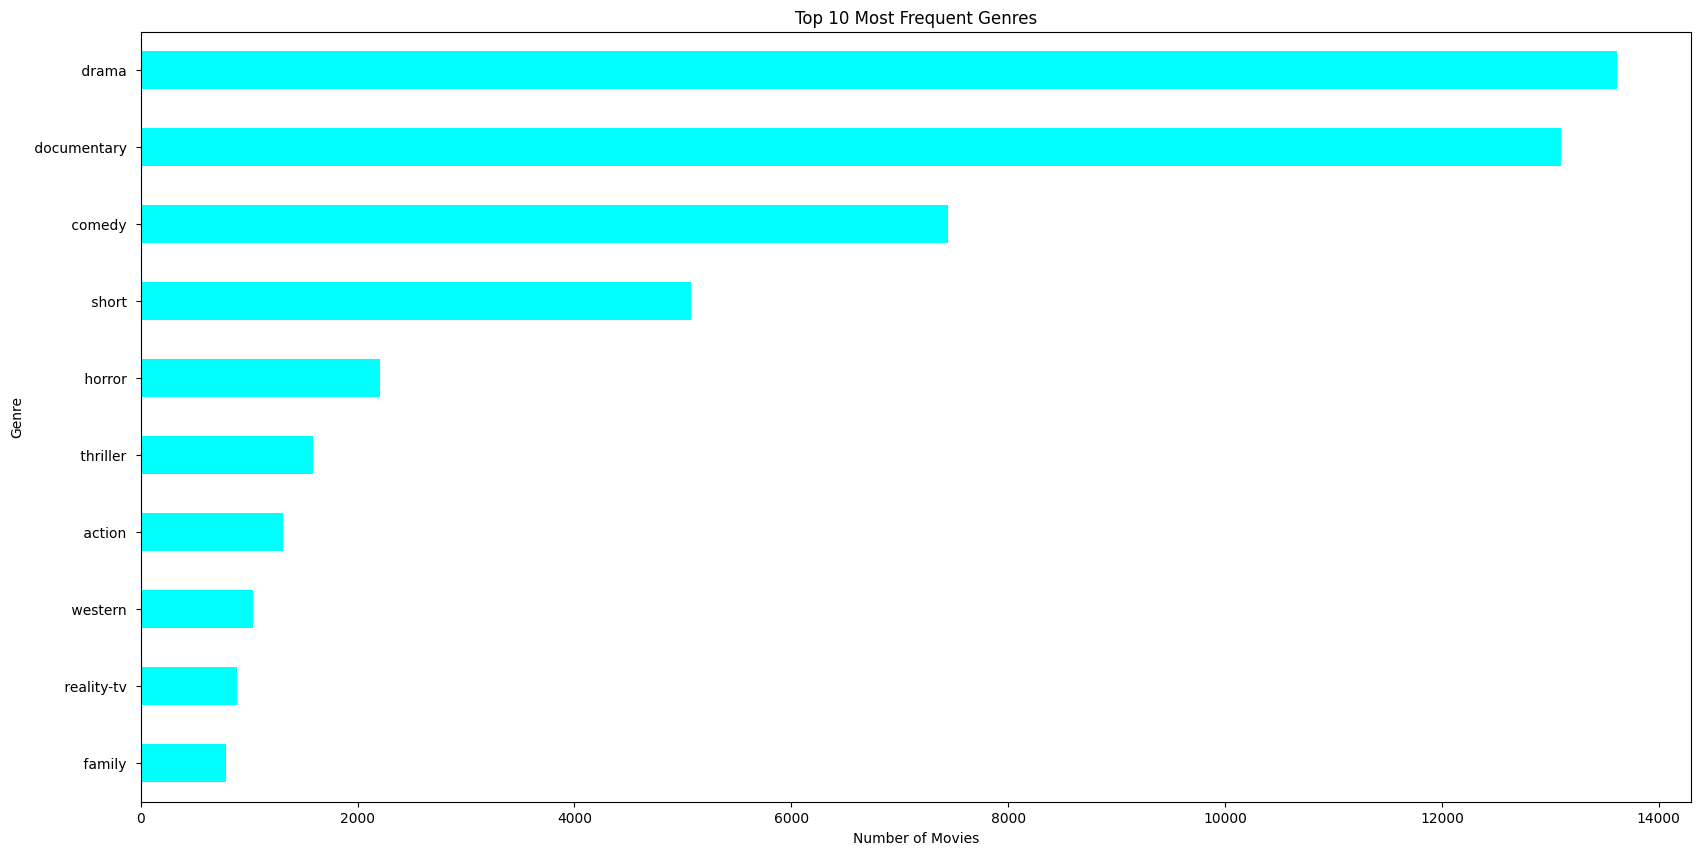

In [17]:
top_genres = train_data['GENRE'].value_counts().head(10)

plt.figure(figsize=(20, 10))
top_genres.plot(kind='barh', color='cyan')
plt.title('Top 10 Most Frequent Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.gca().invert_yaxis()
plt.show()

In [18]:
# Handle any potential missing values
train_data['DESCRIPTION'].fillna("", inplace=True)
test_data['DESCRIPTION'].fillna("", inplace=True)

t_v = TfidfVectorizer(stop_words='english', max_features=100000)
X_train = t_v.fit_transform(train_data['DESCRIPTION'])
X_test = t_v.transform(test_data['DESCRIPTION'])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['GENRE'])
y_test = label_encoder.transform(test_solution_data['GENRE'])

In [19]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

clf = LinearSVC()
clf.fit(X_train_sub, y_train_sub)

y_val_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.5836945494789265
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.32      0.37       263
           1       0.74      0.44      0.55       112
           2       0.45      0.21      0.28       139
           3       0.47      0.15      0.23       104
           4       0.00      0.00      0.00        61
           5       0.53      0.59      0.56      1443
           6       0.39      0.07      0.11       107
           7       0.69      0.81      0.75      2659
           8       0.56      0.72      0.63      2697
           9       0.36      0.17      0.23       150
          10       0.13      0.03      0.04        74
          11       0.82      0.68      0.74        40
          12       0.00      0.00      0.00        45
          13       0.65      0.66      0.66       431
          14       0.61      0.53      0.57       144
          15       0.25      0.04      0.07        50
      

In [20]:
y_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.09357933579335793
Test Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1314
           1       0.00      0.00      0.00       590
           2       0.00      0.00      0.00       775
           3       0.00      0.00      0.00       498
           4       0.00      0.00      0.00       264
           5       0.00      0.00      0.00      7446
           6       0.00      0.00      0.00       505
           7       0.00      0.00      0.00     13096
           8       0.00      0.00      0.00     13612
           9       0.00      0.00      0.00       783
          10       0.00      0.00      0.00       322
          11       0.00      0.00      0.00       193
          12       0.00      0.00      0.00       243
          13       0.00      0.00      0.00      2204
          14       0.00      0.00      0.00       731
          15       0.00      0.00      0.00       276
          16     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.naive_bayes import MultinomialNB
Mnb_classifier = MultinomialNB()
Mnb_classifier.fit(X_train, y_train)

MultinomialNB()

In [24]:
Mnb_classifier.predict(X_test)

array([8, 8, 8, ..., 8, 8, 8])

In [25]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(max_iter=500)
lr_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [26]:
lr_classifier.predict(X_test)

array([8, 8, 8, ..., 8, 8, 8])

In [27]:
def predict_movie(description):
    t_v1 = t_v.transform([description])
    pred_label = clf.predict(t_v1)
    return label_encoder.inverse_transform(pred_label)[0]

sample_descr_for_movie = "A movie where police cashes the criminal and shoot him"
print(predict_movie(sample_descr_for_movie))

sample_descr_for_movie1 = "A movie where person cashes a girl too get marry with him but girl refuses him."
print(predict_movie(sample_descr_for_movie1))

 action 
 drama 
